In [37]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [38]:
# Loads the data required for detecting the license plates from cascade classifier.
plate_cascade = cv2.CascadeClassifier('indian_license_plate.xml')

In [39]:
def detect_plate(img, text=''):
    plate_img = img.copy()
    roi = img.copy()
    # Adjust scaleFactor to be greater than 1
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor=1.2, minNeighbors=7)
    
    for (x, y, w, h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x, y), (x+w, y+h), (51, 181, 155), 3)
        
    if text != '':
        # Modify the text placement as needed
        plate_img = cv2.putText(plate_img, text, (x-w//2, y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (51, 181, 155), 1, cv2.LINE_AA)
        
    return plate_img, plate


In [40]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [41]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

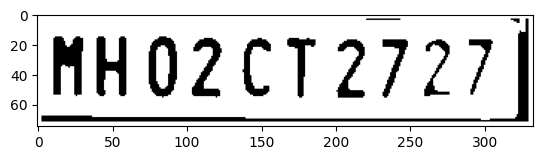

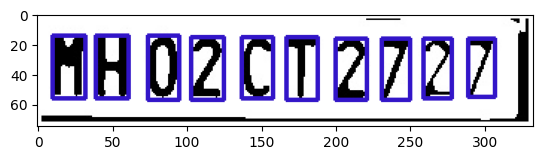

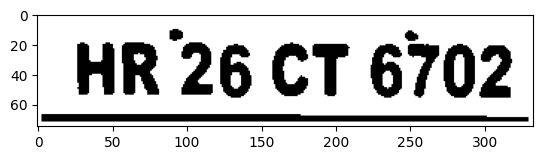

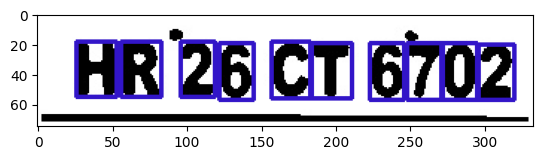

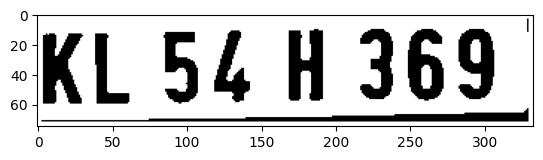

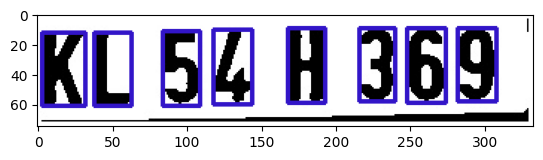

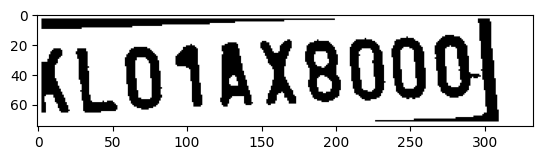

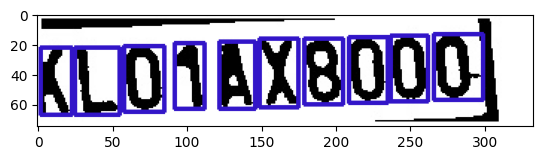

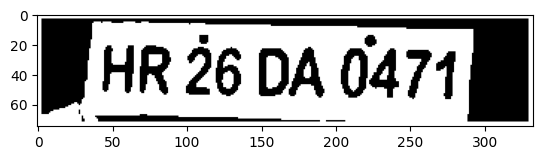

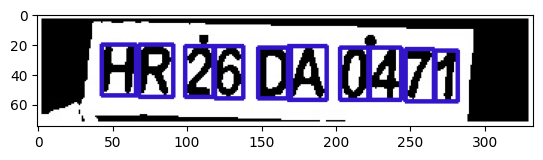

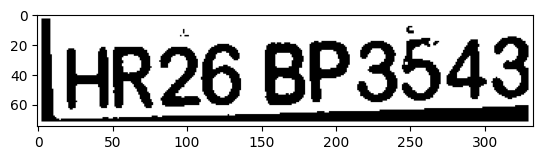

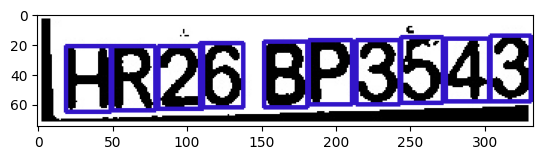

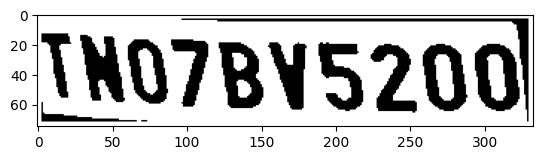

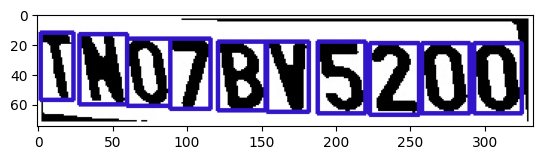

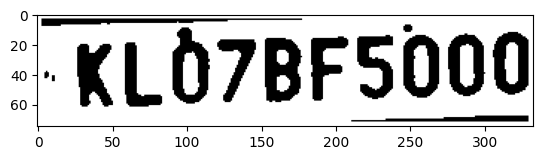

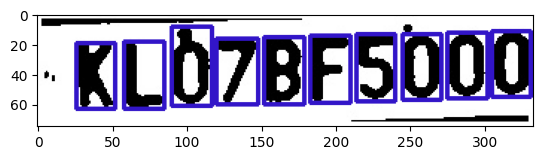

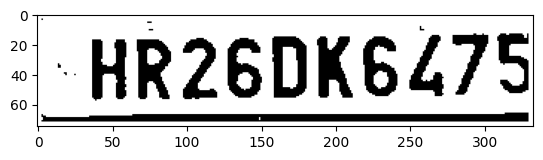

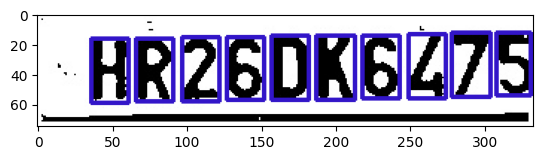

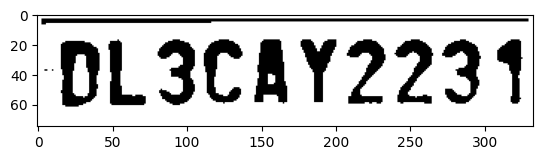

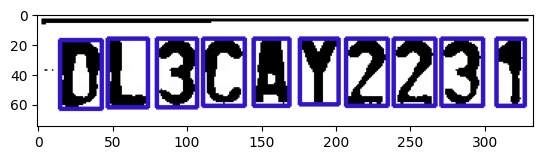

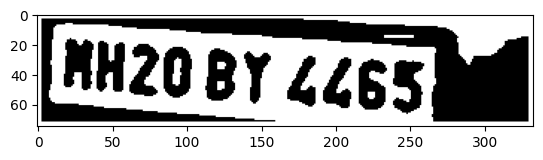

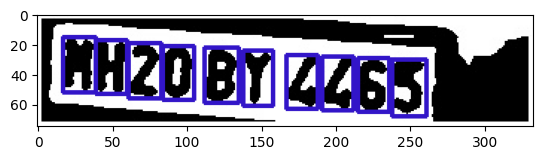

In [42]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def process_images_in_folder(folder_path):
    characters_array = []  # Array to store segmented characters

    # Get a list of all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    # Iterate through each image file in the folder
    for image_file in image_files:
        # Read the image
        img = cv2.imread(os.path.join(folder_path, image_file))

        # Getting plate from the processed image
        output_img, plate = detect_plate(img)

        # Segment characters from the license plate
        char = segment_characters(plate)
        characters_array.append(char)  # Store segmented characters

    return characters_array  # Return the array of segmented characters

# Call the function to process images in the folder
characters = process_images_in_folder('testing-folder/')

In [43]:
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.models import Model

# Define the input shape of the ResNet50 model
input_shape = (224, 224, 3)

# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add more aggressive data augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Define the input shape for the ImageDataGenerator
img_height, img_width = 224, 224
batch_size = 36

# Define your Keras model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


# Define the input shape of the ResNet50 model
input_shape = (224, 224, 3)

# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a new top layer to the model
x = base_model.output
x = Flatten()(x)
x = Dense(36, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define the input shape for the ImageDataGenerator
img_height, img_width = 224, 224
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    "D:/try try/data/data/train",
    target_size=(img_height, img_width),
    batch_size=36,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'D:/try try/data/data/val',
    target_size=(img_height, img_width),
    batch_size=36,
    class_mode='categorical')

# Calculate steps_per_epoch and validation_steps
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps)

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.
Epoch 1/10
24/24 [==============================] - 120s 4s/step - loss: 6.8042 - accuracy: 0.4896 - val_loss: 8190.3022 - val_accuracy: 0.0278
Epoch 2/10
24/24 [==============================] - 98s 4s/step - loss: 2.0119 - accuracy: 0.7812 - val_loss: 42.6604 - val_accuracy: 0.0278
Epoch 3/10
24/24 [==============================] - 98s 4s/step - loss: 1.0519 - accuracy: 0.8646 - val_loss: 32.0437 - val_accuracy: 0.0278
Epoch 4/10
24/24 [==============================] - 99s 4s/step - loss: 0.7084 - accuracy: 0.8970 - val_loss: 89.7736 - val_accuracy: 0.0278
Epoch 5/10
24/24 [==============================] - 97s 4s/step - loss: 0.4867 - accuracy: 0.9329 - val_loss: 31.3458 - val_accuracy: 0.0278
Epoch 6/10
24/24 [==============================] - 98s 4s/step - loss: 0.3191 - accuracy: 0.9375 - val_loss: 19.4390 - val_accuracy: 0.0278
Epoch 7/10
24/24 [==============================] - 97s 4s/step - l

In [44]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model



# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Plot the model architecture
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

 rmalization)                                                                                     
                                                                                                  
 conv2_block1_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block1_0_conv (Conv2  (None, 56, 56, 256)          16640     ['pool1_pool[0][0]']          
 D)                                                                                               
                                                                                                  
 conv2_block1_3_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block1_2_relu[0][0]'] 
 D)                                                                                               
          

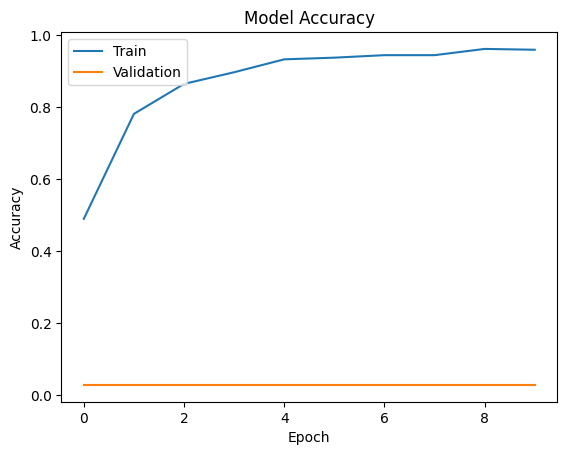

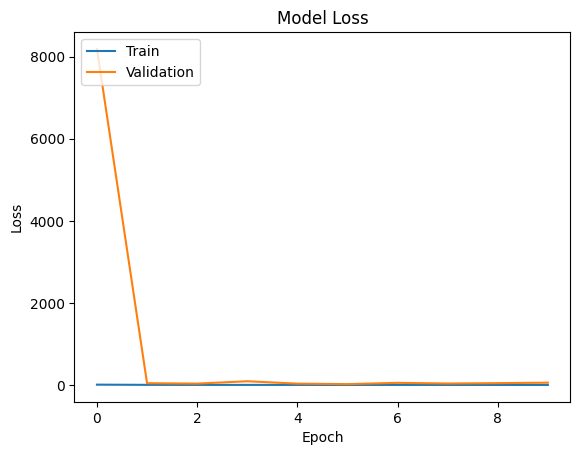

In [45]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [67]:
import cv2
import numpy as np
from keras.models import load_model

def show_results(characters):
    dic = {}
    characters_map = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters_map):
        dic[i] = c

    output = []

    for ch in characters[4]: # accessing the characters of the 7th image (index 6)
        img = cv2.resize(ch, (80,80), interpolation=cv2.INTER_AREA)  # Resize to match model input shape
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        img = np.repeat(img, 3, axis=-1)  # Convert grayscale to RGB by repeating the single channel 3 times
        model = load_model('models.h5') 
        y_pred_probs = model.predict(img)

        # Convert probabilities to class predictions
        y_pred_classes = y_pred_probs.argmax(axis=-1)[0]  # Assuming there's only one prediction
        character = dic[y_pred_classes]
        output.append(character)  # storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

# Assuming you have the 'characters' variable defined somewhere before calling show_results
print(show_results(characters))


1/1 [==============================] - 0s 100ms/step
HR26DA0471


In [65]:
predicted_plate = show_results(characters)
ground_truth_plate = 'HR26DA0471'  # Assuming this is the ground truth plate number

# Calculate accuracy
correct_predictions = sum(1 for pred, truth in zip(predicted_plate, ground_truth_plate) if pred == truth)
total_characters = len(ground_truth_plate)
accuracy = correct_predictions / total_characters

print("Accuracy:", accuracy)


1/1 [==============================] - 0s 26ms/step
Accuracy: 1.0


1/1 [==============================] - 0s 25ms/step


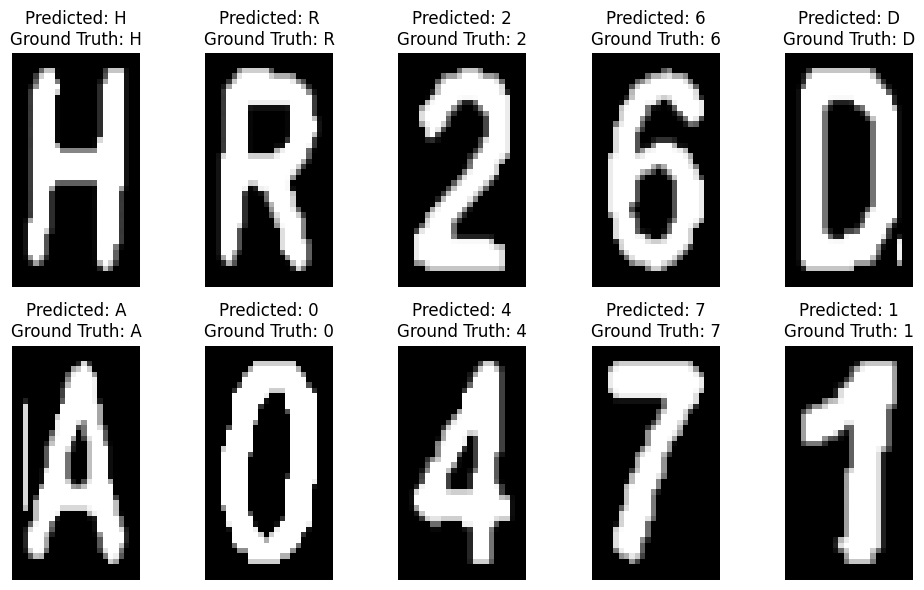

In [66]:
import matplotlib.pyplot as plt

predicted_plate = show_results(characters)
ground_truth_plate = 'HR26DA0471'  # Assuming this is the ground truth plate number

# Plot characters along with ground truth labels
plt.figure(figsize=(10, 6))
for i, (pred_char, truth_char) in enumerate(zip(predicted_plate, ground_truth_plate)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(characters[4][i], cmap='gray')  # assuming 7th image characters are being plotted
    plt.title(f'Predicted: {pred_char}\nGround Truth: {truth_char}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Epoch 1/10
24/24 [==============================] - 105s 4s/step - loss: 0.7521 - accuracy: 0.8958 - f1_m: 0.8987 - precision_m: 0.9017 - recall_m: 0.8958 - val_loss: 1104.4324 - val_accuracy: 0.0278 - val_f1_m: 0.0278 - val_precision_m: 0.0278 - val_recall_m: 0.0278
Epoch 2/10
24/24 [==============================] - 94s 4s/step - loss: 0.4144 - accuracy: 0.9340 - f1_m: 0.9340 - precision_m: 0.9340 - recall_m: 0.9340 - val_loss: 12998.7676 - val_accuracy: 0.0278 - val_f1_m: 0.0278 - val_precision_m: 0.0278 - val_recall_m: 0.0278
Epoch 3/10
24/24 [==============================] - 94s 4s/step - loss: 0.4372 - accuracy: 0.9329 - f1_m: 0.9329 - precision_m: 0.9329 - recall_m: 0.9329 - val_loss: 36.2736 - val_accuracy: 0.0324 - val_f1_m: 0.0325 - val_precision_m: 0.0327 - val_recall_m: 0.0324
Epoch 4/10
24/24 [==============================] - 94s 4s/step - loss: 0.4173 - accuracy: 0.9410 - f1_m: 0.9410 - precision_m: 0.9410 - recall_m: 0.9410 - val_loss: 63.8235 - val_accuracy: 0.0278 - 

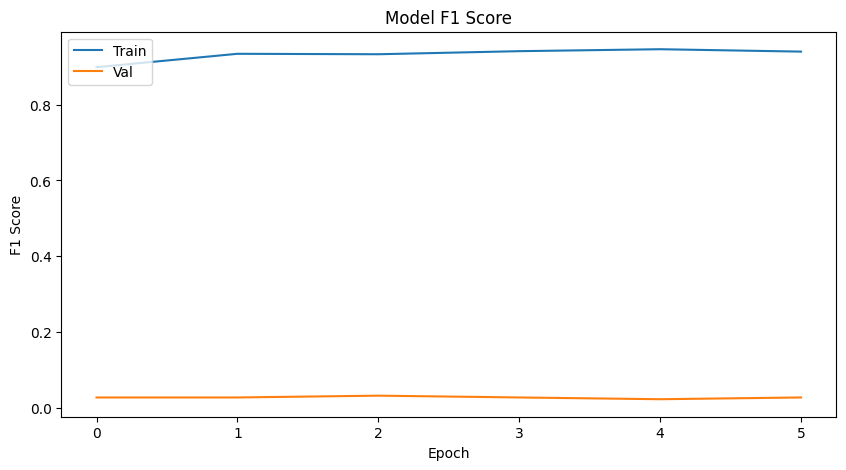

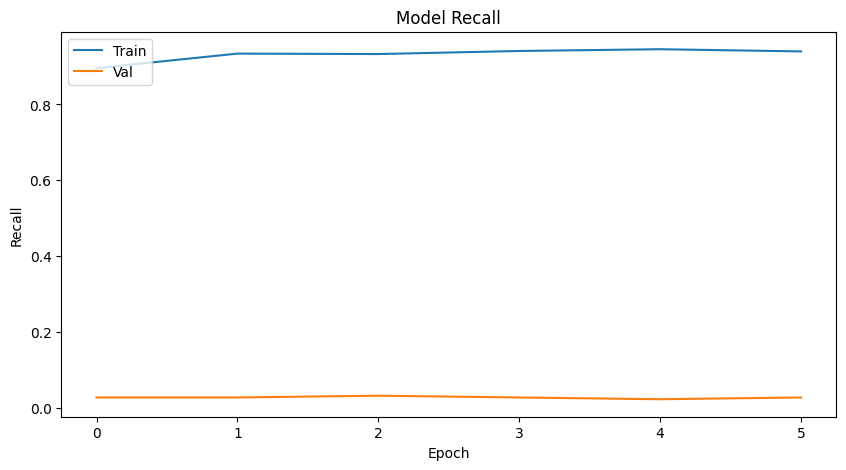

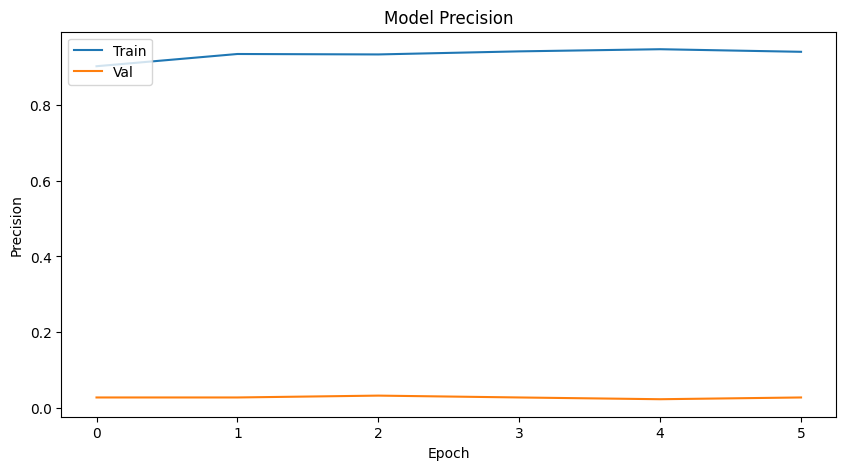

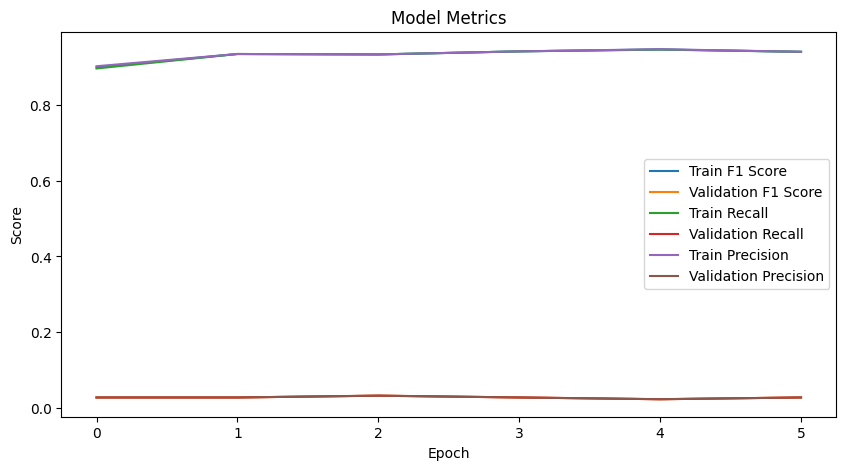

In [49]:
from keras import backend as K
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Define the optimizer
optimizer = Adam()
# define optimizer
optimizer = Adam(learning_rate=0.001)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Fit the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=10,  # You can adjust the number of epochs here
    callbacks=[early_stopping]
)

# plot metrics
plt.figure(figsize=(10, 5))
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


import matplotlib.pyplot as plt

# Plot metrics
plt.figure(figsize=(10, 5))

# F1 Score
plt.plot(history.history['f1_m'], label='Train F1 Score')
plt.plot(history.history['val_f1_m'], label='Validation F1 Score')

# Recall
plt.plot(history.history['recall_m'], label='Train Recall')
plt.plot(history.history['val_recall_m'], label='Validation Recall')

# Precision
plt.plot(history.history['precision_m'], label='Train Precision')
plt.plot(history.history['val_precision_m'], label='Validation Precision')

plt.title('Model Metrics')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend()
plt.show()
